In [35]:
import os
import copy
import numpy as np
import pandas as pd
import pydicom
import nibabel as nib

from scipy import ndimage as nd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as transforms
import torch.utils.data as data

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, ShuffleSplit
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import roc_auc_score, r2_score, accuracy_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore")

%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:           125G         61G         56G        294M        7.7G         63G
Swap:           14G         14G        298M


In [37]:
!nvidia-smi

Thu Oct  8 22:23:03 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   30C    P0    27W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:89:00.0 Off |                    0 |
| N/A   61C    P0   168W / 250W |  13999MiB / 16280MiB |    100%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [38]:
use_cuda = torch.cuda.is_available()

print("Torch version:", torch.__version__)
if use_cuda:
    print("Using GPU")
else:
    print("Not using GPU")

device = 2

Torch version: 1.5.0
Using GPU


In [ ]:
# 1.configs & utils
from utils import *

# 2.models
from models import Flatten, Reshape

# 3.loss
# from loss import compute_preds, compute_probs

# 4.dataloader & transforms
from data_loader_abide import ABIDEMRI, CPACMRI
from transforms import *

torch.backends.cudnn.enabled = True

In [ ]:
from matplotlib.colors import rgb2hex

def get_colors(cmap, breaks):
    return [rgb2hex(cmap(bb)) for bb in breaks]

def display_brain(dataset, i):
    n = dataset[i]
    print(n.shape)
    if len(n.shape) == 4:
        n = n[0]
    elif len(n.shape) == 5:
        n = n[0, 0]
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.imshow(n[n.shape[0] // 2, :, :])
    plt.subplot(132)
    plt.imshow(n[:, n.shape[1] // 2, :])
    plt.subplot(133)
    plt.imshow(n[:, :, n.shape[2] // 2])
    plt.show()
    
def display_brain_img(img, vmin=None, vmax=None, cmap="viridis", site=""):
    n = img[0]
    plt.figure(figsize=(12, 5))
    plt.subplot(131)
    plt.imshow(n[n.shape[0] // 2, :, :].T[::-1], vmin=vmin, vmax=vmax, cmap=cmap)
    plt.ylabel(site, fontdict={"size" : 20})
    plt.yticks([], [])
    plt.xticks([], [])
    plt.subplot(132)
    plt.imshow(n[:, n.shape[1] // 2, :].T[::-1], vmin=vmin, vmax=vmax, cmap=cmap)
    plt.axis('off')
    plt.subplot(133)
    plt.imshow(n[:, :, n.shape[2] // 2], vmin=vmin, vmax=vmax, cmap=cmap)
    plt.axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

In [ ]:
class Encoder3d(nn.Module):
    def __init__(self, 
                 img_shape=(1, 64, 64, 64), 
                 conv_model=[32, 64, 128, 256],
                 lrelu_slope=0.2,
                 noises=[0, 0, 0, 0]):
        super(self.__class__, self).__init__()
        img_shape = np.array(img_shape)
        self.n_layers = len(conv_model)
        
        self.model = []
        C_in = img_shape[0]
        for i, C_out in enumerate(conv_model):
            self.model += [
                nn.Dropout3d(noises[i]),
                nn.Conv3d(C_in, C_out, 4, 2, 1, bias=False),
                nn.BatchNorm3d(C_out),
                nn.LeakyReLU(lrelu_slope, inplace=True),
            ]
            C_in = C_out
            
        print(C_out, "activations of size:", 
              list(img_shape[1:] // (2 ** self.n_layers)))
        self.model = nn.Sequential(*self.model)
    
    def forward(self, x):
        return self.model(x)

In [ ]:
class Decoder3d(nn.Module):
    def __init__(self, 
                 latent_shape=(256, 4, 4, 4), 
#                  img_shape=(1, 64, 64, 64),
                 conv_model=[128, 64, 32, 1]):
        super(self.__class__, self).__init__()
        self.latent_shape = np.array(latent_shape)
#         img_shape = np.array(img_shape)
        self.n_layers = len(conv_model)
        
        self.model = []
        C_in = latent_shape[0]
        for C_out in conv_model:
            self.model += [
                nn.ConvTranspose3d(C_in, C_out, 4, 2, 1, bias=False),
                nn.BatchNorm3d(C_out),
                nn.ReLU(inplace=True),
            ]
            C_in = C_out
            
        print(C_out, "activations of size:", 
              list(self.latent_shape[1:] * (2 ** self.n_layers)))
        self.model = nn.Sequential(*self.model)
    
    def forward(self, x):
        return self.model(x)

In [ ]:
# encoder + decoder or aenc architecture

class Autoencoder3d(nn.Module):
    def __init__(self, 
                 img_shape=(1, 64, 64, 64), 
                 enc_conv_model=[32, 64, 128, 256],
                 lrelu_slope=0.2,
                 noises=[0, 0, 0, 0]):
        super(self.__class__, self).__init__()
        self.img_shape = np.array(img_shape)
        self.enc_conv_model = enc_conv_model
        self.dec_conv_model = enc_conv_model[-2::-1] + [img_shape[0]]
        self.n_layers = len(enc_conv_model)
        self.latent_shape = np.array([enc_conv_model[-1]] + list(self.img_shape[1:] // (2 ** self.n_layers)))
        self.lrelu_slope = lrelu_slope
        
        self.encoder = nn.Sequential(
            Encoder3d(img_shape,
                      self.enc_conv_model,
                      lrelu_slope,
                      noises),
            nn.Conv3d(self.latent_shape[0], self.latent_shape[0], 3, 1, 1),
        )
        
        self.decoder = nn.Sequential(
            Decoder3d(self.latent_shape, 
                      self.dec_conv_model),
            nn.Conv3d(self.dec_conv_model[-1], 1, 3, 1, 1, bias=True),
#             nn.ReLU(inplace=True)
#             nn.Sigmoid() # -> normalize images to (0, 1)
        )
        
    def encode(self, x):
        z = self.encoder(x) # z repr is 4d tensor 
        return z
    
    def decode(self, z):
        x_rec = self.decoder(z)
        return x_rec

    def forward(self, x):        
        z = self.encode(x)
        x_rec = self.decode(z)
        return x_rec, z

In [ ]:
def train_enc(train_loader, val_loader, args,
              AE, AE_opt, device,
              AE_crit=nn.MSELoss()):
    
    def plot_results(epoch):
        clear_output(True)
        print("EPOCH {}".format(epoch))
        
        plt.figure(figsize=(15, 6))
        plt.subplot(111)
        plt.plot(train_stats["rec_loss"], label="train_rec_loss")
        plt.plot(train_stats["val rec_loss"], label="val rec_loss")
        plt.legend()
        plt.show()
        
        print("Train recon")
        i = np.random.choice(len(train_loader.dataset))
        img = train_loader.dataset[i]
        display_brain_img(img.detach().numpy(), vmin=0., vmax=1.)
        img_recon, _ = AE(img.unsqueeze(dim=0).to(device))
        display_brain_img(img_recon.cpu().detach().numpy()[0], vmin=0., vmax=1.)
        print("Val recon")
        i = np.random.choice(len(val_loader.dataset))
        img = val_loader.dataset[i]
        display_brain_img(img.detach().numpy(), vmin=0., vmax=1.)
        img_recon, _ = AE(img.unsqueeze(dim=0).to(device))
        display_brain_img(img_recon.cpu().detach().numpy()[0], vmin=0., vmax=1.)
        
        print("  rec loss (in-iteration): \t{:.6f}".format(train_stats["rec_loss"][-1]))
        print("  val rec loss: \t{:.6f}".format(train_stats["val rec_loss"][-1]))
        
    train_stats = {
        "rec_loss" : [],
        "val rec_loss" : [],
    }
    
    for epoch in range(args["n_epochs"]):
        print("TRAIN EPOCH {}...".format(epoch))
        epoch_train_stats = {
            "rec_loss" : [],
            "val rec_loss" : [],
        }
        
        AE.train(True)
        # here train_loader returns x, y, a 
        for inputs_batch in tqdm(train_loader):
            inputs_batch = inputs_batch.to(device)
            
            # train AE
            recons_batch, latents_batch = AE(inputs_batch)
            rec_loss = AE_crit(recons_batch, inputs_batch)
            AE_opt.zero_grad()
            rec_loss.backward()
            AE_opt.step()
            epoch_train_stats["rec_loss"].append(rec_loss.item())
            
        
        AE.train(False)
        for inputs_batch in tqdm(val_loader):
            inputs_batch = inputs_batch.to(device)

            recons_batch, latents_batch = AE(inputs_batch)
            rec_loss = AE_crit(recons_batch, inputs_batch)
            epoch_train_stats["val rec_loss"].append(rec_loss.item())
            
        # add mean stats
        for stat_name in epoch_train_stats:
            if stat_name in train_stats:
                train_stats[stat_name].append(np.mean(epoch_train_stats[stat_name]))
        
        plot_results(epoch)
        
    return train_stats

In [ ]:
class LatentDiscriminator(nn.Module):
    def __init__(self,
                 latent_shape, # takes decoder.latent_shape
                 n_attrs_outputs,
                 conv_model=[512],
                 fc_model=[],
                 dropout=0,
                 batchnorm=True):
        super().__init__()
        self.latent_shape = np.array(latent_shape)
        self.n_attrs_outputs = n_attrs_outputs
        self.n_outputs = sum(n_attrs_outputs)
        self.n_layers = len(conv_model)
        
        self.model = []
        C_in = latent_shape[0]
        for C_out in conv_model:
            self.model += [
                nn.Conv3d(C_in, C_out, 3, 2, 1, bias=False),
                nn.BatchNorm3d(C_out),
                nn.ReLU(inplace=True),
            ]
            C_in = C_out
            
        self.model += [
            nn.AdaptiveAvgPool3d((1, 1, 1)),
            Flatten()
        ]
        
        n_in = C_in
        for n_out in fc_model:
            self.model += [nn.Dropout(dropout),
                           nn.Linear(n_in, n_out)]
            if batchnorm:
                self.model += [nn.BatchNorm1d(n_out)]
            self.model += [
                nn.ReLU(True),
            ]
            n_in = n_out
        self.model += [nn.Dropout(dropout),
                       nn.Linear(n_in, self.n_outputs)]
        self.model = nn.Sequential(*self.model)

    def forward(self, z):
        z = self.model(z)
        return z
    
###############################################################################    
    
class FaderDecoder3d(nn.Module):
    def __init__(self, 
                 latent_shape=(256, 4, 4, 4), 
#                  img_shape=(1, 64, 64, 64),
                 conv_model=[128, 64, 32, 1],
                 n_attrs_outputs=[],
                ):
        super(self.__class__, self).__init__()
        self.latent_shape = np.array(latent_shape)
#         img_shape = np.array(img_shape)
        self.n_layers = len(conv_model)
        self.n_attrs_outputs = n_attrs_outputs # list of n_outputs for each attr
        self.n_attrs_channels = sum(n_attrs_outputs)
        
        self.model = []
        C_in = latent_shape[0]
        for C_out in conv_model:
            self.model += [
                nn.ConvTranspose3d(C_in + self.n_attrs_channels, C_out, 4, 2, 1, bias=False),
                nn.BatchNorm3d(C_out),
                nn.ReLU(inplace=True),
            ]
            C_in = C_out
            
        print(C_out, "activations of size:", 
              list(self.latent_shape[1:] * (2 ** self.n_layers)))
        self.model = nn.Sequential(*self.model)
    
    def forward(self, x, attrs):
        for i in range(len(self.model)):
            # we should add attrs channels to each x before apply conv
            # assume attrs here are already one-hot-encoded vectors
            # so just create 1s-channels and multiply them object-wise
            if i % 3 == 0:
                bs, C, h, w, d = x.size()
                attrs_C = torch.ones(bs, self.n_attrs_channels, h, w, d).to(x)
                attrs_C *= attrs.view(bs, self.n_attrs_channels, 1, 1, 1).float()
                x = torch.cat((x, attrs_C), dim=1) # channelwise
            x = self.model[i](x)
        return x
    
###############################################################################        

# encoder + decoder or aenc architecture

class FaderNet3d(nn.Module):
    def __init__(self, 
                 img_shape=(1, 64, 64, 64), 
                 enc_conv_model=[32, 64, 128, 256],
                 lrelu_slope=0.2,
                 noises=[0, 0, 0, 0, 0],
                 n_attrs_outputs=[],
                ):
        super(self.__class__, self).__init__()
        self.img_shape = np.array(img_shape)
        self.enc_conv_model = enc_conv_model
        self.dec_conv_model = enc_conv_model[-2::-1] + [img_shape[0]]
        self.n_layers = len(enc_conv_model)
        self.latent_shape = np.array([enc_conv_model[-1]] + list(self.img_shape[1:] // (2 ** self.n_layers)))
        self.lrelu_slope = lrelu_slope
        self.n_attrs_outputs = n_attrs_outputs
        
        self.encoder = nn.Sequential(
            Encoder3d(img_shape,
                      self.enc_conv_model,
                      lrelu_slope,
                      noises),
            nn.Conv3d(self.latent_shape[0], self.latent_shape[0], 3, 1, 1),
        )
        
        self.decoder = FaderDecoder3d(self.latent_shape, 
                                      self.dec_conv_model,
                                      n_attrs_outputs)
        self.decoder_output = nn.Sequential(
            nn.Conv3d(self.dec_conv_model[-1], 1, 3, 1, 1, bias=True),
#             nn.ReLU(inplace=True)
#             nn.Sigmoid() # -> normalize images to (0, 1)
        )
        
    def encode(self, x):
        z = self.encoder(x) # z repr is 4d tensor 
        return z
    
    def decode(self, z, attrs):
        x_rec = self.decoder(z, attrs)
        x_rec = self.decoder_output(x_rec)
        return x_rec

    def forward(self, x, attrs):        
        z = self.encode(x)
        x_rec = self.decode(z, attrs)
        return x_rec, z

In [39]:
def train_fadernet(train_loader, val_loader, args,
                   AE, D, AE_opt, D_opt, device,
                   AE_crit=nn.MSELoss(), D_crit=nn.BCEWithLogitsLoss(),
                   freq=1, cmap="viridis",
                   site_labels=['BNI', 'EMC', 'GU', 'IP', 'KKI', 'NYU', 'OHSU', 'SDSU'],
                   subgroup_labels=[],
                   train_stats=None):
    
    def plot_results(epoch, freq):
        clear_output(True)
        print("EPOCH {}".format(epoch))
        
        plt.figure(figsize=(20, 6))
        plt.subplot(121)
        plt.plot(train_stats["AE_loss"], label="AE_loss")
        plt.plot(train_stats["rec_loss"], label="train_rec_loss")
        plt.plot(train_stats["val rec_loss"], label="val rec_loss")
        plt.subplot(122)
        plt.plot(train_stats["D_loss"], label="D_loss")
        plt.plot(train_stats["LR_auc_CV"], label="LR_auc_CV")
        plt.plot(train_stats["LR_auc_LSO"], label="LR_auc_LSO")
        plt.legend()
        plt.show()
        
        print("Train recon")
        i = np.random.choice(len(train_loader.dataset))
        img, _, attrs = train_loader.dataset[i]
        print(torch.argmax(attrs))
        display_brain_img(img.detach().numpy(), vmin=0., vmax=1.)
        img, attrs = img.unsqueeze(dim=0).to(device), attrs.unsqueeze(dim=0).to(device)
        img_recon, _ = AE(img, attrs)
        display_brain_img(img_recon.cpu().detach().numpy()[0], vmin=0., vmax=1.)
        print("Val recon")
        i = np.random.choice(len(val_loader.dataset))
        img, _, attrs = val_loader.dataset[i]
        print(torch.argmax(attrs))
        display_brain_img(img.detach().numpy(), vmin=0., vmax=1.)
        img, attrs = img.unsqueeze(dim=0).to(device), attrs.unsqueeze(dim=0).to(device)
        img_recon, _ = AE(img, attrs)
        display_brain_img(img_recon.cpu().detach().numpy()[0], vmin=0., vmax=1.)
        
        print("  AE loss: \t\t\t{:.6f}".format(train_stats["AE_loss"][-1]))
        print("  rec loss (in-iteration): \t{:.6f}".format(train_stats["rec_loss"][-1]))
        print("  D loss: \t\t\t{:.6f}".format(train_stats["D_loss"][-1]))
        print("  val rec loss: \t{:.6f}".format(train_stats["val rec_loss"][-1]))
        print("  LR auc CV: \t{:.6f}".format(train_stats["LR_auc_CV"][-1]))
        print("  LR auc LSO: \t{:.6f}".format(train_stats["LR_auc_LSO"][-1]))
        
        if (epoch + 1) % freq == 0:
            Z = epoch_train_stats["Z_val"]
            sites = epoch_train_stats["sites_val"]
            pca = PCA(n_components=50)
            Z_red = pca.fit_transform(Z)
            tsne = TSNE(n_components=2)
            Z_2d = tsne.fit_transform(Z_red)

            plt.figure(figsize=(10, 6))
            colors = get_colors(plt.get_cmap(cmap), np.linspace(0.05, 0.9, len(site_labels)))

            if len(subgroup_labels) > 0:
                for sg in np.unique(subgroup_labels):
                    idx_sg = (subgroup_labels == sg)
                    for i in range(len(site_labels)):
                        plt.scatter(Z_2d[(sites == i) * idx_sg, 0], Z_2d[(sites == i) * idx_sg, 1], 
                                    s=30, c=colors[i], marker="${}$".format(sg),
                                    alpha=0.8, label=site_labels[i] if sg == 0 else None)
            else:
                for i in range(len(site_labels)):
                    plt.scatter(Z_2d[sites == i, 0], Z_2d[sites == i, 1], 
                                s=30, c=colors[i], alpha=1, label=site_labels[i])
            plt.legend()
    #         plt.xticks([],[])
    #         plt.yticks([],[])
            plt.show()
        
    train_stats = {
        "D_loss" : [],
        "rec_loss" : [],
        "AE_loss" : [],
        "val rec_loss" : [],
        "LR_auc_CV" : [],
        "LR_auc_LSO" : [],
    } if train_stats is None else train_stats
    
    for epoch in range(args["n_epochs"]):
        print("TRAIN EPOCH {}...".format(epoch))
        epoch_train_stats = {
            "D_loss" : [],
            "rec_loss" : [],
            "AE_loss" : [],
            "val rec_loss" : [],
            "Z_val" : [],
            "y_val" : [],
            "sites_val" : [],
            "LR_auc_CV" : [],
            "LR_auc_LSO" : [],
        }
        
        D_n_upd = args["D_n_upd"] if args["n_pretr_epochs"] <= epoch < args["n_pretr_epochs"] + args["D_loop_epochs"] else 1
        
        if args["lambda_scheduler"] == "linear":
            if epoch <= args["n_pretr_epochs"]:
                cur_lambda = args["min_lambda"]
            elif cur_lambda < args["max_lambda"]:
                cur_lambda += args["inc_lambda"]
            else: 
                cur_lambda = args["max_lambda"]
        elif args["lambda_scheduler"] == "exp":
            p = epoch / args["n_epochs"]
            cur_lambda = (2 / (1 + np.exp(-args["lambda_gamma"] * p)) - 1) * args["max_lambda"]
        print(cur_lambda)
        
        D.train(True)
        AE.train(True)
        # here train_loader returns x, y, a 
        for inputs_batch, _, attrs_batch in tqdm(train_loader):
            inputs_batch, attrs_batch = inputs_batch.to(device), attrs_batch.to(device)
            
            # train D
            # use D to predict attrs from latent reprs
            # encode inputs & attrs with AE
            recons_batch, latents_batch = AE(inputs_batch, attrs_batch)
            for _ in range(D_n_upd):
                outputs_batch = D(latents_batch.detach())
                D_loss = D_crit(outputs_batch, attrs_batch)
                if epoch > args["n_pretr_epochs"]:
                    D_opt.zero_grad()
                    D_loss.backward()
                    D_opt.step()
            epoch_train_stats["D_loss"].append(D_loss.item())
            
            # train AE
            recons_batch, latents_batch = AE(inputs_batch, attrs_batch)
            rec_loss = AE_crit(recons_batch, inputs_batch)
            outputs_batch = D(latents_batch)
            D_loss = D_crit(outputs_batch, 1 - attrs_batch)   # D_loss = D_crit(outputs_batch, (1 - attrs_batch))
            AE_loss = rec_loss + cur_lambda * D_loss      # AE_loss = rec_loss + cur_lambda * D_loss
            AE_opt.zero_grad()
            AE_loss.backward()
            AE_opt.step()
            epoch_train_stats["rec_loss"].append(rec_loss.item())
            epoch_train_stats["AE_loss"].append(AE_loss.item())
            
        
        AE.train(False)
        for inputs_batch, targets_batch, attrs_batch in tqdm(val_loader):
            inputs_batch, attrs_batch = inputs_batch.to(device), attrs_batch.to(device)

            recons_batch, latents_batch = AE(inputs_batch, attrs_batch)
            rec_loss = AE_crit(recons_batch, inputs_batch)
            epoch_train_stats["val rec_loss"].append(rec_loss.item())
            epoch_train_stats["Z_val"] += list(latents_batch.cpu().detach().numpy().reshape(len(latents_batch), -1))
            epoch_train_stats["y_val"] += list(targets_batch.cpu().detach().numpy())
            epoch_train_stats["sites_val"] += list(attrs_batch.argmax(dim=1).cpu().detach().numpy())
            
        epoch_train_stats["Z_val"] = np.array(epoch_train_stats["Z_val"])
        epoch_train_stats["y_val"] = np.array(epoch_train_stats["y_val"])
        epoch_train_stats["sites_val"] = np.array(epoch_train_stats["sites_val"])
        
        clf = LogisticRegression()
        # CV
        cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
        epoch_train_stats["LR_auc_CV"] = cross_val_score(clf, epoch_train_stats["Z_val"], epoch_train_stats["y_val"], scoring="roc_auc", cv=cv)
        # LSO
        cv = LeaveOneGroupOut()
        epoch_train_stats["LR_auc_LSO"] = cross_val_score(clf, epoch_train_stats["Z_val"], epoch_train_stats["y_val"], 
                                                          groups=epoch_train_stats["sites_val"], scoring="roc_auc", cv=cv)
        
        # add mean stats
        for stat_name in epoch_train_stats:
            if stat_name in train_stats:
                train_stats[stat_name].append(np.mean(epoch_train_stats[stat_name]))
        
        plot_results(epoch, freq)
        
    return train_stats

In [ ]:
import warnings

class RescaleIntensity(object):
    """Rescale intensity values to a certain range.

    Args:
        out_min_max: Range :math:`(n_{min}, n_{max})` of output intensities.
        percentiles: Percentile values of the input image that will be mapped
            to :math:`(n_{min}, n_{max})`. They can be used for contrast
            stretching, as in `this scikit-image example`_. For example,
            Isensee et al. use ``(0.05, 99.5)`` in their `nn-UNet paper`_.
        masking_method: See
            :py:class:`~torchio.transforms.preprocessing.normalization_transform.NormalizationTransform`.
        p: Probability that this transform will be applied.
    """
    def __init__(self, out_min_max, percentiles=(0, 100), masking_method=None):
#             masking_method: TypeMaskingMethod=None,
        super().__init__()
        self.out_min, self.out_max = out_min_max
        self.percentiles = percentiles
        self.masking_method = masking_method
        
    def __call__(self, sample):
        if self.masking_method is None:
            mask = torch.ones_like(sample)
        else:
            mask = self.masking_method(sample)
        return self.rescale(sample, mask)

#     def apply_normalization(self, sample, mask):
#         sample = self.rescale(sample, mask)

    def rescale(self, tensor, mask):
        array = tensor.numpy()
        mask = mask.numpy()
        values = array[mask]
        cutoff = np.percentile(values, self.percentiles)
        np.clip(array, *cutoff, out=array)
        array -= array.min()  # [0, max]
        array_max = array.max()
        if array_max == 0:
            message = (f'Rescaling image not possible due to division by zero')
            warnings.warn(message)
            return tensor
        array /= array.max()  # [0, 1]
        out_range = self.out_max - self.out_min
        array *= out_range  # [0, out_range]
        array += self.out_min  # [out_min, out_max]
        return torch.from_numpy(array)

In [14]:
# пока не придумали ничего лучше, такие скейлы 
# + клипать все, что вышло за пределы
sources_boundaries = {
    "OHSU" : [(8, 0, 0), (48, 64, 36)],
    "KKI" : [(24, 16, 8), (48, 64, 36)],
    "NYU" : [(8, 8, 0), (48, 64, 36)],
    "SDSU" : [(8, 0, 4), (48, 64, 36)],
    "USM" : [(8, 0, 2), (48, 64, 36)],
    "UCLA" : [(8, 0, 0), (48, 64, 36)],
    #
    "IP" : [(8, 0, 0), (48, 64, 36)],
    "OILH" : [(16, 4, 7), (48, 64, 36)],
    "GU" : [(8, 0, 2), (48, 64, 36)],
    "BNI" : [(8, 0, 8), (48, 64, 36)],
    "EMC" : [(8, 0, 0), (48, 64, 36)],
    "TCD" : [(16, 4, 1), (48, 64, 36)],
    "IU" : [(8, 0, 4), (48, 64, 36)],
    "ETH" : [(16, 8, 2), (48, 64, 36)],
    "UCD" : [(8, 0, 0), (48, 64, 36)],
    "all" : [(0, 0, 0), (48, 64, 36)]
}
sources_scales={
#     'KKI': 2500.,
#     'NYU': 300.,
#     'OHSU': 2000.,
#     'SDSU': 10000.,
#     'UCLA': 2000.,
#     'USM': 1800.,
#     #
#     'IP': 4000.,
#     'OILH': 7500.,
#     'GU': 1800.,
#     'BNI': 2500.,
#     'EMC': 10000.,
#     'TCD': 1200.,
#     'IU': 1400.,
#     'ETH': 40000.,
#     'UCD': 2000.,
    'all': 1.,
}

In [15]:
transform = transforms.Compose([
    Pad(padding=(8, 0, 14), img_type="fMRI_tr"),
    ToTensor(),
    RescaleIntensity((0, 1), masking_method=lambda x: x > 0),
])

dataset_abide = ABIDEMRI(paths='../../pominova/adibe2/Outputs/denoise/denoise/',
                  labels_path='../../pominova/ABIDEII_Composite_Phenotypic_150220.csv', # modified targets
                  target=None,
                  encode_target=False,
                  load_online=True, 
                  sub_path="ses-1",
                  mri_type="fMRI", 
                  mri_file_suffix='run-1_bold_denoised_0-16.npy',
                  transform=transform,
                  use_sources=["NYU", "OHSU", "KKI", "GU"],
                  sources_boundaries=sources_boundaries,
                  sources_scales=sources_scales,
                  clip=False,
                  start_pos=0, 
                  seq_len=4,
                  domain_target=None,
                 )

100%|██████████| 1006/1006 [00:03<00:00, 313.54it/s]


In [16]:
sources = dataset_abide.labels["SOURCE"].value_counts().index
dataset_abide.set_target("DX_GROUP")
idx = dataset_abide.target.notnull()
idx =  dataset_abide.labels.index[idx]
sources = dataset_abide.labels["SOURCE"][idx].value_counts().index
dataset_abide.set_target()
print(sources)
print(len(idx))

Index(['KKI', 'NYU', 'OHSU', 'GU'], dtype='object')
484


KKI 211 torch.Size([4, 1, 64, 64, 64])


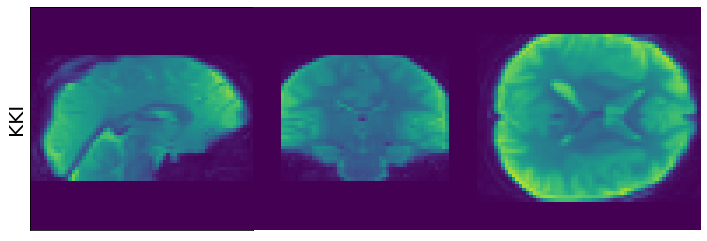

NYU 105 torch.Size([4, 1, 64, 64, 64])


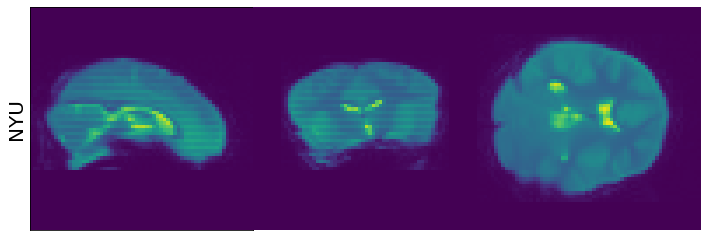

OHSU 93 torch.Size([4, 1, 64, 64, 64])


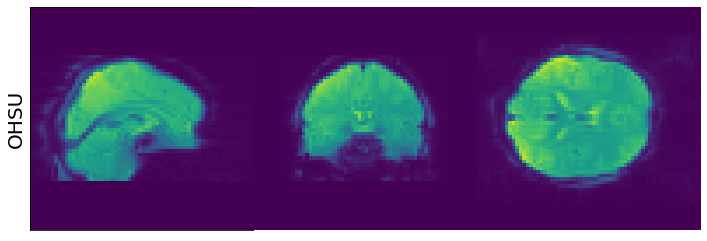

GU 75 torch.Size([4, 1, 64, 64, 64])


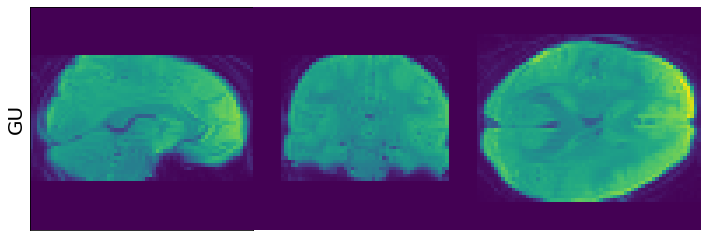

In [18]:
cmap = "viridis"

for s in sources:
    s_idx = idx[dataset_abide.labels.loc[idx, "SOURCE"] == s]
    i = s_idx[0]
#     img = load_nii_to_array(dataset_abide.mri_files[i])
    img = dataset_abide[i]
    print(s, len(s_idx), img.shape)
#     display_brain_img([img], site=dataset_abide.labels["SOURCE"][i], cmap=cmap, vmin=0., vmax=None, axis=True)
    display_brain_img(img[0].numpy(), site=dataset_abide.labels["SOURCE"][i], cmap=cmap, vmin=0., vmax=1.)

KKI 211 torch.Size([4, 1, 64, 64, 64])


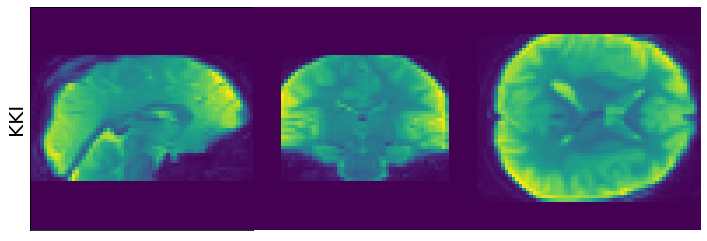

NYU 105 torch.Size([4, 1, 64, 64, 64])


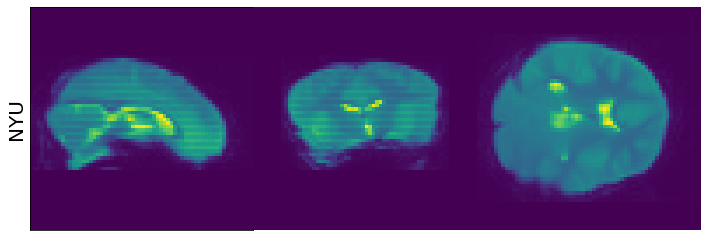

OHSU 93 torch.Size([4, 1, 64, 64, 64])


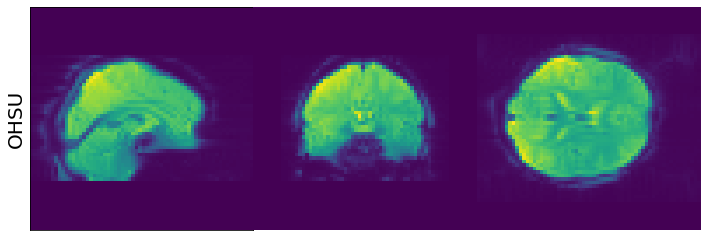

GU 75 torch.Size([4, 1, 64, 64, 64])


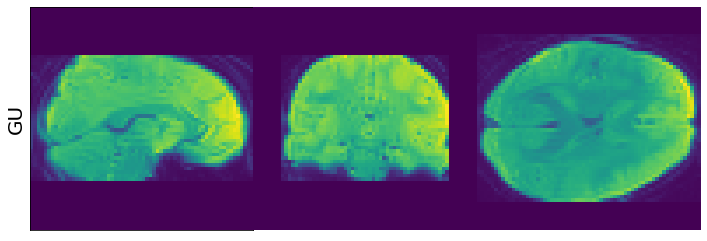

In [41]:
cmap = "viridis"

for s in sources:
    s_idx = idx[dataset_abide.labels.loc[idx, "SOURCE"] == s]
    i = s_idx[0]
#     img = load_nii_to_array(dataset_abide.mri_files[i])
    img = dataset_abide[i]
    print(s, len(s_idx), img.shape)
#     display_brain_img([img], site=dataset_abide.labels["SOURCE"][i], cmap=cmap, vmin=0., vmax=None, axis=True)
    display_brain_img(img[0].numpy(), site=dataset_abide.labels["SOURCE"][i], cmap=cmap, vmin=0., vmax=None)

In [17]:
dataset_abide.labels["SOURCE"].value_counts()

KKI     211
NYU     105
OHSU     93
GU       75
BNI      58
SDSU     58
IP       55
EMC      54
OILH     53
TCD      42
IU       40
ETH      37
USM      33
UCD      32
UCLA     32
KUL      28
Name: SOURCE, dtype: int64

In [18]:
dataset_abide.set_target("DX_GROUP", True, domain_target="SOURCE");
select_indices = dataset_abide.labels.index[dataset_abide.target.notnull()]
len(select_indices)

484

In [53]:
# create a tensor with train dataset
tensors_abide = []
targets_abide = []
sources_abide = []
for i in tqdm(select_indices):
    x, y, a = dataset_abide[i]
#     print(x.size())
    tensors_abide.append(x)
    targets_abide.append(y)
    sources_abide.append(a)

100%|██████████| 484/484 [00:50<00:00,  9.52it/s]


In [57]:
tensors_abide = torch.cat(tensors_abide, dim=0)
print(tensors_abide.size())
torch.save(tensors_abide, "tensors/fmri-4sl_abide2_z-norm_4-sites")

torch.Size([1936, 1, 64, 64, 64])


In [58]:
targets_abide = torch.Tensor(targets_abide)
print(targets_abide.size())
torch.save(targets_abide, "tensors/targets_abide2_4-sites")

torch.Size([484])


In [59]:
sources_abide = torch.Tensor(sources_abide)
print(sources_abide.size())
torch.save(sources_abide, "tensors/sources_abide2_4-sites")

torch.Size([484])


In [56]:
set((list(zip(sources_abide.numpy(), dataset_abide.labels.loc[select_indices, "SOURCE"].tolist()))))

{(0.0, 'GU'), (1.0, 'KKI'), (2.0, 'NYU'), (3.0, 'OHSU')}

torch.Size([1936, 1, 64, 64, 64]) torch.Size([1936]) torch.Size([1936])
tensor(0.) tensor(0.9894)


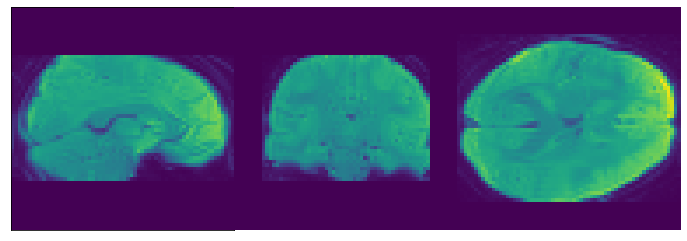

In [19]:
tensors_abide = torch.load("tensors/fmri-4sl_abide2_z-norm_4-sites")
targets_abide = torch.load("tensors/targets_abide2_4-sites")
sources_abide = torch.load("tensors/sources_abide2_4-sites")

targets_abide = targets_abide.repeat(4, 1).t().reshape(-1)
sources_abide = sources_abide.repeat(4, 1).t().reshape(-1)

print(tensors_abide.size(), targets_abide.size(), sources_abide.size())
n = tensors_abide[3] # random tensor
print(n.min(), n.max())
display_brain_img(tensors_abide[3].numpy(), vmin=0., vmax=1.)

In [20]:
sources_abide_ohe = []
for v in sources_abide.unique():
    sources_abide_ohe.append((sources_abide == v).float())
sources_abide_ohe = torch.stack(sources_abide_ohe, dim=-1)
print(sources_abide_ohe.size())


# attrs_abide = torch.cat((sources_abide_ohe, age_groups_abide_ohe), dim=-1)
attrs_abide = sources_abide_ohe
print(attrs_abide.size())

torch.Size([1936, 4])
torch.Size([1936, 4])


In [21]:
site_labels = [l[1] for l in sorted({
    (0.0, 'GU'), (1.0, 'KKI'), (2.0, 'NYU'), (3.0, 'OHSU')
})]
site_labels

['GU', 'KKI', 'NYU', 'OHSU']

In [22]:
general_args = {
    # opt
    "learning_rate" : 3e-5,
    "weight_decay" : 0,
    # scheduler
    "step_size" : 50,
    "gamma" : 0.5, # lr *= gamma
    # training
    "batch_size" : 128,
    "n_epochs" : 100,
    "epsilon" : 0,
    "n_splits" : 10,
    "n_repeats" : 1,
    "mode" : "clf",
    # model
    "img_shape" : (1, 64, 64, 64),
    "n_outputs" : 2,
    "conv_model" : [32, 64, 128, 256, 512],
    "lrelu_slope" : 0.2,
    "noises" : [0, 0, 0, 0, 0],
    "n_attrs_outputs" : [4],
    # disc
    "D_conv_model" : [512],
    "D_fc_model" : [512, 256, 128, 64, 32],
    "D_dropout" : 0.3,
    "D_batchnorm" : True,
    # D_training
    "D_learning_rate" : 1e-5,
    "D_n_upd" : 5,
    "D_loop_epochs" : 100,
    "n_pretr_epochs" : 0,
    "min_lambda" : 0,
    "inc_lambda" : 1e-2 / 200,
    "max_lambda" : 1e-2,
    "lambda_scheduler" : "linear",
    "lambda_gamma" : 10,
}

In [23]:
def create_model(args):
    AE = FaderNet3d(
        args["img_shape"],
        args["conv_model"],
        args["lrelu_slope"],
        args["noises"],
        args["n_attrs_outputs"],
    )
    AE = AE.to(device)
    
    D = LatentDiscriminator(
        AE.decoder.latent_shape,
        args["n_attrs_outputs"],
        args["D_conv_model"],
        args["D_fc_model"],
        args["D_dropout"],
        args["D_batchnorm"]
    )
    D = D.to(device)
    
    AE_opt = torch.optim.Adam(AE.parameters(), lr=args["learning_rate"], 
                           weight_decay=args["weight_decay"])
    D_opt = torch.optim.Adam(D.parameters(), lr=args["D_learning_rate"], 
                           weight_decay=args["weight_decay"])
    return AE, D, AE_opt, D_opt

In [27]:
args = {k : v for k, v in general_args.items()}
args.update({
    "batch_size" : 64,
    "learning_rate" : 1e-4,
    "D_learning_rate" : 3e-5,
    "n_epochs" : 100,
    "n_pretr_epochs" : 0, # no lambda increment
    # Fadernet
    "img_shape" : (1, 64, 64, 64),
    "conv_model" : [32, 64, 128, 256, 512],
    "lrely_slope" : 0.2,
    "noises" : [0, 0, 0, 0, 0, 0],
    "n_attrs_outputs" : [4],
    # disc
    "D_conv_model" : [],
    "D_fc_model" : [512, 128, 32],
    "D_dropout" : 0.3,
    "D_batchnorm" : True,
    # D_training
    "D_n_upd" : 5,
    "D_loop_epochs" : 100,
    "min_lambda" : 0,
    "inc_lambda" : 3e-3 / 100,
    "max_lambda" : 3e-3,
})

tensor_dataset = data.TensorDataset(tensors_abide, targets_abide, attrs_abide)
# train on whole, val on random subset (since we ~know that perf is same for train and val)
idx = np.arange(len(tensor_dataset))
train_idx = idx#[::8]
val_idx = idx[::4]
print(len(val_idx))
print(site_labels)
train_loader = torch.utils.data.DataLoader(
    data.Subset(tensor_dataset, train_idx), batch_size=args["batch_size"], shuffle=True)
val_loader = torch.utils.data.DataLoader(
    data.Subset(tensor_dataset, val_idx), batch_size=args["batch_size"], shuffle=False)
# set target for domain classification
AE, D, AE_opt, D_opt = create_model(args)
train_stats = {"D_loss" : [], "rec_loss" : [], "AE_loss" : [], "val rec_loss" : [], "LR_auc" : [],}

484
['GU', 'KKI', 'NYU', 'OHSU']
512 activations of size: [2, 2, 2]
1 activations of size: [64, 64, 64]


In [35]:
# compare

# - check with constatnly growing d-loss weight

In [24]:
args = {k : v for k, v in general_args.items()}
args.update({
    "batch_size" : 64,
    "learning_rate" : 1e-4,
    "D_learning_rate" : 3e-5,
    "n_epochs" : 100,
    "n_pretr_epochs" : 0, # no lambda increment
    # Fadernet
    "img_shape" : (1, 64, 64, 64),
    "conv_model" : [32, 64, 128, 256, 512],
    "lrely_slope" : 0.2,
    "n_attrs_outputs" : [4],
    # disc
    "D_conv_model" : [],
    "D_fc_model" : [512, 128, 32],
    "D_dropout" : 0.3,
    "D_batchnorm" : True,
    # D_training
    "D_n_upd" : 5,
    "D_loop_epochs" : 100,
    "min_lambda" : 0,
    "inc_lambda" : 2e-3 / 100,
    "max_lambda" : 10e-3,
})

tensor_dataset = data.TensorDataset(tensors_abide, targets_abide, attrs_abide)
# train on whole, val on random subset (since we ~know that perf is same for train and val)
idx = np.arange(len(tensor_dataset))
train_idx = idx#[::8]
val_idx = idx[::4]
print(len(val_idx))
print(site_labels)
train_loader = torch.utils.data.DataLoader(
    data.Subset(tensor_dataset, train_idx), batch_size=args["batch_size"], shuffle=True)
val_loader = torch.utils.data.DataLoader(
    data.Subset(tensor_dataset, val_idx), batch_size=args["batch_size"], shuffle=False)
# set target for domain classification
AE, D, AE_opt, D_opt = create_model(args)
train_stats = {"D_loss" : [], "rec_loss" : [], "AE_loss" : [], "val rec_loss" : [], "LR_auc" : [],}

484
['GU', 'KKI', 'NYU', 'OHSU']
512 activations of size: [2, 2, 2]
1 activations of size: [64, 64, 64]


In [33]:
train_stats["LR_auc_CV"] = train_stats["LR_auc"]
train_stats["LR_auc_LSO"] = [np.nan for _ in range(len(train_stats["LR_auc"]))]

print(len(train_stats["LR_auc_CV"]))
for k in train_stats:
    print(k, train_stats[k][-1])

200
D_loss 0.5334307214906139
rec_loss 0.0008947197122559432
AE_loss 0.0058118738834896395
val rec_loss 0.0009471947196288966
LR_auc 0.613618039808516
LR_auc_CV 0.613618039808516
LR_auc_LSO nan


EPOCH 0


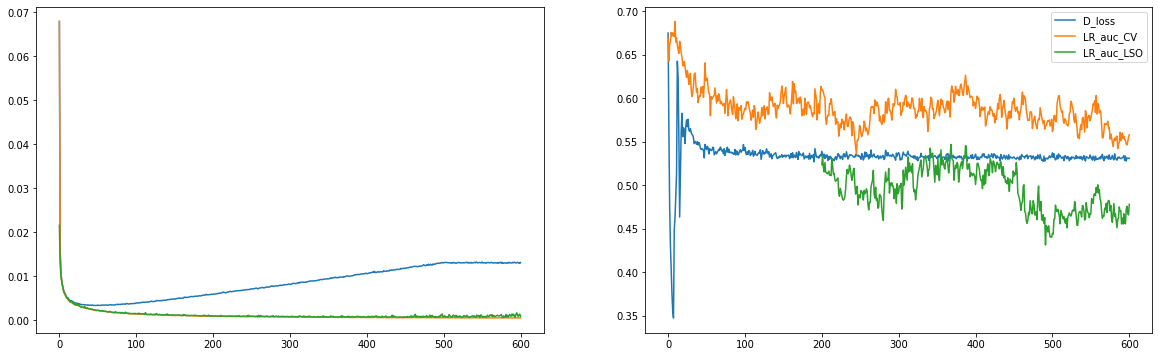

Train recon
tensor(0)


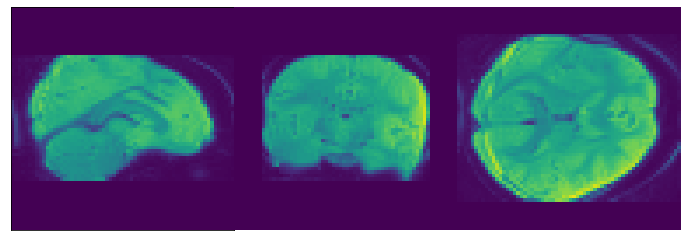

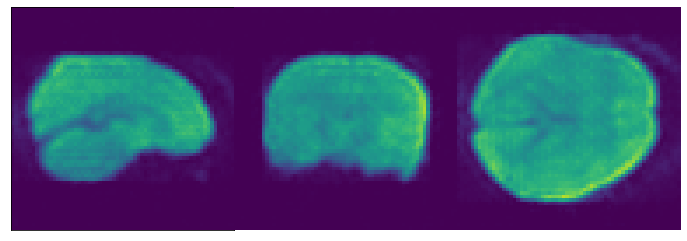

Val recon
tensor(2)


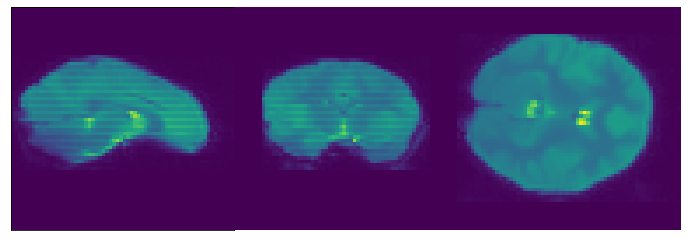

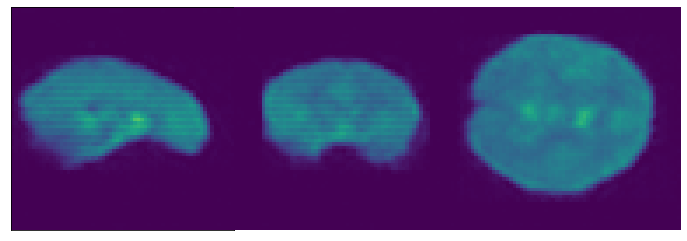

  0%|          | 0/31 [00:00<?, ?it/s]

  AE loss: 			0.013085
  rec loss (in-iteration): 	0.000490
  D loss: 			0.531036
  val rec loss: 	0.000853
  LR auc CV: 	0.557902
  LR auc LSO: 	0.478061
TRAIN EPOCH 1...
0.01


 81%|████████  | 25/31 [01:30<00:21,  3.61s/it]


KeyboardInterrupt: 

In [44]:
args["n_epochs"] = 100
args["min_lambda"] = 10e-3
train_stats = train_fadernet(train_loader, val_loader, args, 
                             AE, D, AE_opt, D_opt, device, 
                             AE_crit=nn.MSELoss(), D_crit=nn.BCEWithLogitsLoss(),
                             site_labels=site_labels, train_stats=train_stats,
                             freq=10)

In [52]:
args = {k : v for k, v in general_args.items()}
args.update({
    "batch_size" : 64,
    "learning_rate" : 1e-4,
    "D_learning_rate" : 3e-5,
    "n_epochs" : 100,
    "n_pretr_epochs" : 0, # no lambda increment
    # Fadernet
    "img_shape" : (1, 64, 64, 64),
    "conv_model" : [32, 64, 128, 256],
    "lrely_slope" : 0.2,
    "noises" : [0, 0, 0, 0, 0],
    "n_attrs_outputs" : [4],
    # disc
    "D_conv_model" : [256],
    "D_fc_model" : [256, 64],
    "D_dropout" : 0.3,
    "D_batchnorm" : True,
    # D_training
    "D_n_upd" : 5,
    "D_loop_epochs" : 100,
    "min_lambda" : 0,
    "inc_lambda" : 1e-3 / 100,
    "max_lambda" : 1e-3,
})

tensor_dataset = data.TensorDataset(tensors_abide, targets_abide, attrs_abide)
# train on whole, val on random subset (since we ~know that perf is same for train and val)
idx = np.arange(len(tensor_dataset))
train_idx = idx#[::8]
val_idx = idx[::4]
print(len(val_idx))
print(site_labels)
train_loader = torch.utils.data.DataLoader(
    data.Subset(tensor_dataset, train_idx), batch_size=args["batch_size"], shuffle=True)
val_loader = torch.utils.data.DataLoader(
    data.Subset(tensor_dataset, val_idx), batch_size=args["batch_size"], shuffle=False)
# set target for domain classification
AE, D, AE_opt, D_opt = create_model(args)
train_stats = {"D_loss" : [], "rec_loss" : [], "AE_loss" : [], 
               "val rec_loss" : [], "LR_auc_CV" : [], "LR_auc_LSO" : [],} 

484
['GU', 'KKI', 'NYU', 'OHSU']
256 activations of size: [4, 4, 4]
1 activations of size: [64, 64, 64]


EPOCH 49


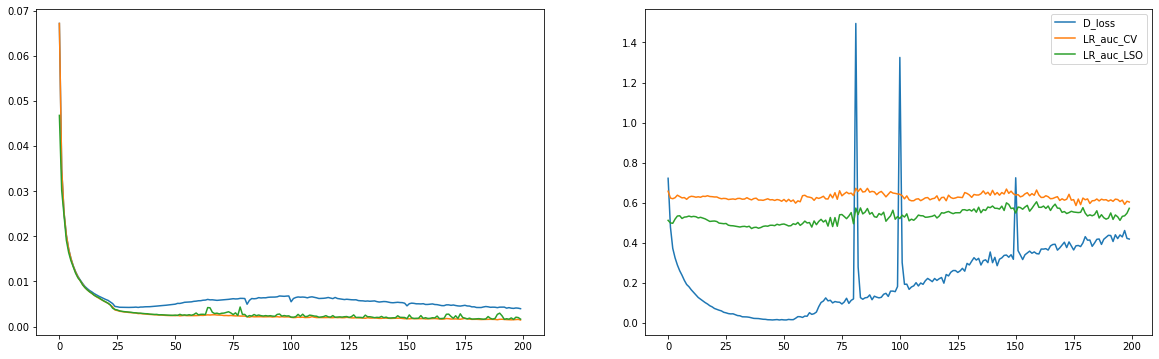

Train recon
tensor(1)


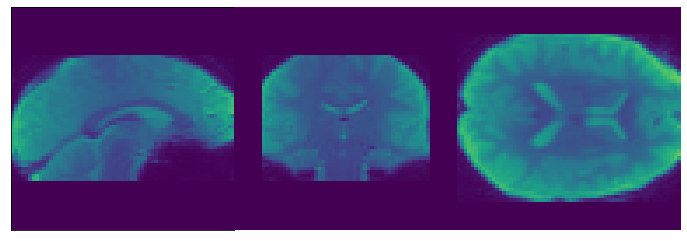

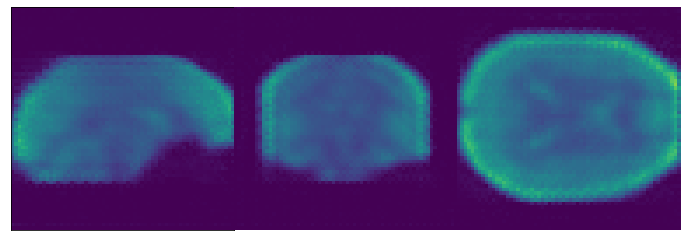

Val recon
tensor(2)


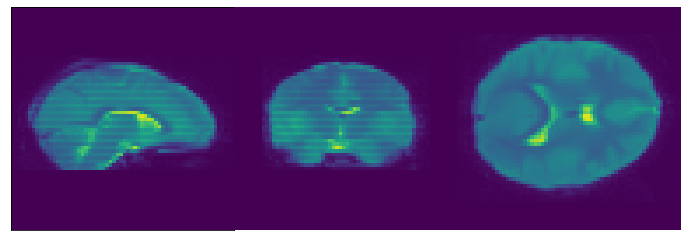

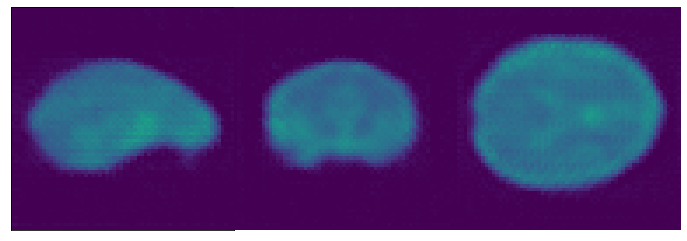

  AE loss: 			0.003955
  rec loss (in-iteration): 	0.001450
  D loss: 			0.419218
  val rec loss: 	0.001638
  LR auc CV: 	0.603847
  LR auc LSO: 	0.572572


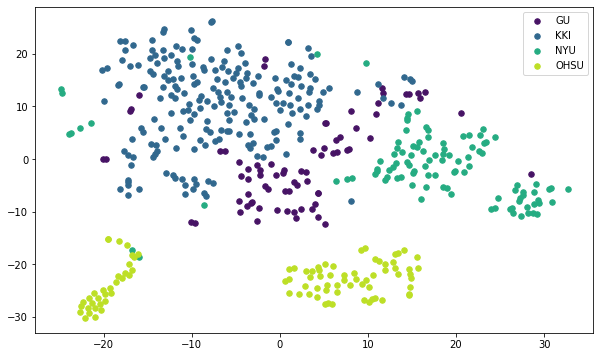

In [62]:
args["n_epochs"] = 50
args["min_lambda"] = 1e-3
train_stats = train_fadernet(train_loader, val_loader, args, 
                             AE, D, AE_opt, D_opt, device, 
                             AE_crit=nn.MSELoss(), D_crit=nn.BCEWithLogitsLoss(),
                             site_labels=site_labels, train_stats=train_stats,
                             freq=10)

In [58]:
name = "FaderAE3d_ABIDE2-fmri-4slices-4sites_{}_epochs({})".format(
    "-".join(map(str, args["conv_model"])),
    len(train_stats["rec_loss"])
)
print(name)
torch.save({
    'train_stats' : train_stats,
    'model_state_dict': AE.state_dict(),
    'optimizer_state_dict': AE_opt.state_dict(),
    'disc_state_dict': D.state_dict(),
    'disc_optimizer_state_dict': D_opt.state_dict(),
}, "weights/{}.pth".format(name))

FaderAE3d_ABIDE2-fmri-4slices-4sites_32-64-128-256_epochs(100)


In [54]:
# 

In [ ]:
# for next training, modify train to draw embs only each n epochs

In [23]:
args = {k : v for k, v in general_args.items()}
args.update({
    "batch_size" : 64,
    "learning_rate" : 1e-4,
    "D_learning_rate" : 3e-5,
    "n_epochs" : 100,
    "n_pretr_epochs" : 0, # no lambda increment
    # Fadernet
    "img_shape" : (1, 64, 64, 64),
    "conv_model" : [32, 64, 128, 256, 512, 1024],
    "lrely_slope" : 0.2,
    "noises" : [0, 0, 0, 0, 0, 0],
    "n_attrs_outputs" : [4],
    # disc
    "D_conv_model" : [],
    "D_fc_model" : [1024, 256, 64],
    "D_dropout" : 0.3,
    "D_batchnorm" : True,
    # D_training
    "D_n_upd" : 5,
    "D_loop_epochs" : 100,
    "min_lambda" : 0,
    "inc_lambda" : 3e-3 / 100,
    "max_lambda" : 3e-3,
})

tensor_dataset = data.TensorDataset(tensors_abide, targets_abide, attrs_abide)
# train on whole, val on random subset (since we ~know that perf is same for train and val)
idx = np.arange(len(tensor_dataset))
train_idx = idx#[::8]
val_idx = idx[::4]
print(len(val_idx))
print(site_labels)
train_loader = torch.utils.data.DataLoader(
    data.Subset(tensor_dataset, train_idx), batch_size=args["batch_size"], shuffle=True)
val_loader = torch.utils.data.DataLoader(
    data.Subset(tensor_dataset, val_idx), batch_size=args["batch_size"], shuffle=False)
# set target for domain classification
AE, D, AE_opt, D_opt = create_model(args)
train_stats = {"D_loss" : [], "rec_loss" : [], "AE_loss" : [], "val rec_loss" : [], "LR_auc" : [],}

484
['GU', 'KKI', 'NYU', 'OHSU']
1024 activations of size: [1, 1, 1]
1 activations of size: [64, 64, 64]


EPOCH 199


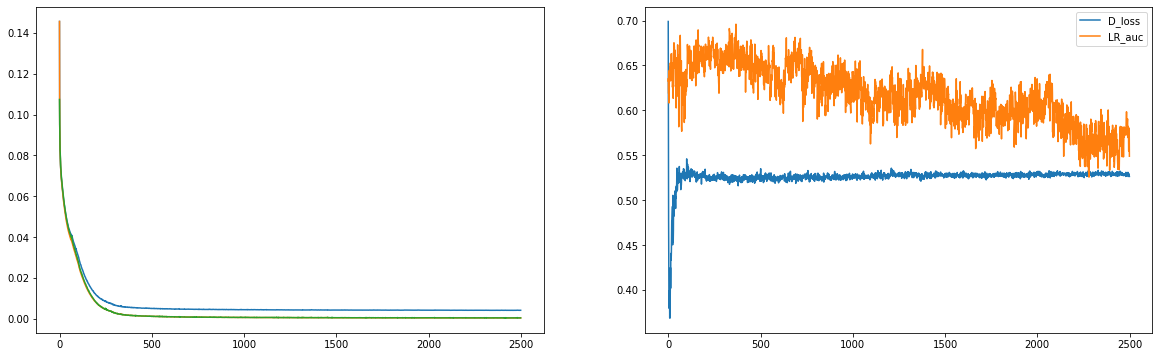

Train recon
tensor(2)


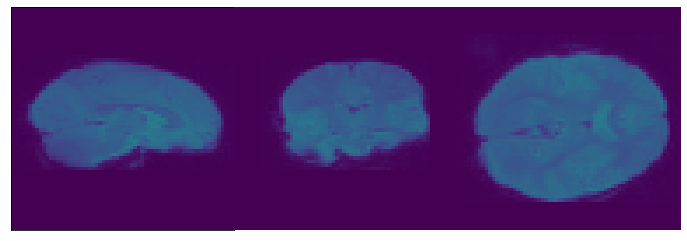

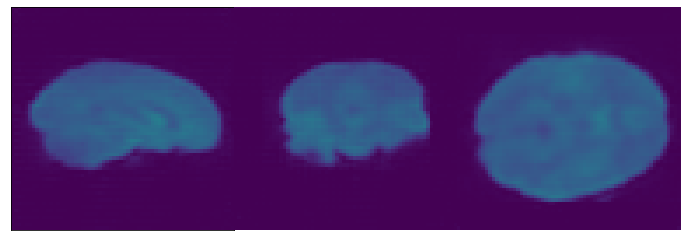

Val recon
tensor(0)


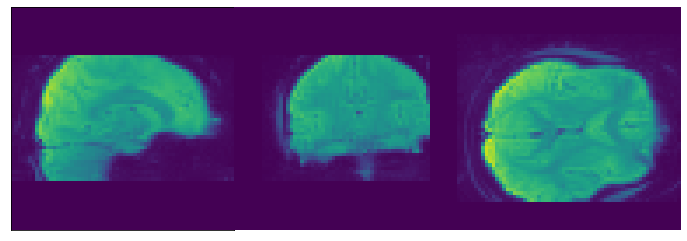

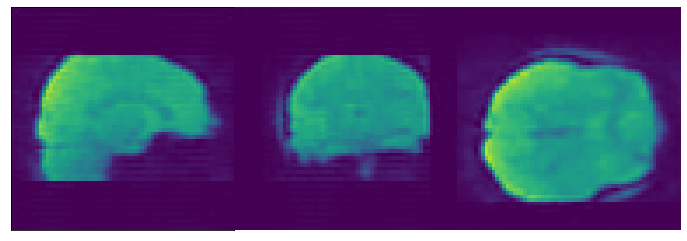

  AE loss: 			0.004139
  rec loss (in-iteration): 	0.000378
  D loss: 			0.526339
  val rec loss: 	0.000415
  LR auc: 	0.548868


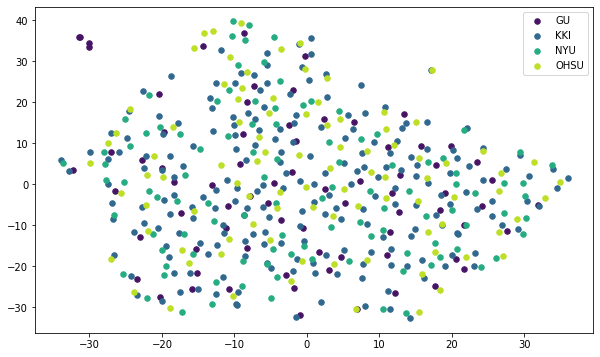

In [56]:
args.update({
    "n_epochs" : 200,
    # D_training
    "D_n_upd" : 5,
    "D_loop_epochs" : 200,
    "min_lambda" : 3e-3,
    "inc_lambda" : 3e-3 / 100,
    "max_lambda" : 3e-3,
})
train_stats = train_fadernet(train_loader, val_loader, args, 
                             AE, D, AE_opt, D_opt, device, 
                             AE_crit=nn.MSELoss(), D_crit=nn.BCEWithLogitsLoss(),
                             site_labels=site_labels, train_stats=train_stats)

In [65]:
len(train_stats["LR_auc"]), train_stats["LR_auc"][-1]

(2500, 0.5488684177374654)

In [67]:
name = "FaderAE3d_ABIDE2-fmri-4slices-4sites_{}".format(
    "-".join(map(str, args["conv_model"])),
)
print(name)
torch.save({
    'train_stats' : train_stats,
    'model_state_dict': AE.state_dict(),
    'optimizer_state_dict': AE_opt.state_dict(),
    'D_model_state_dict': D.state_dict(),
    'D_optimizer_state_dict': D_opt.state_dict(),
}, "weights/{}.pth".format(name))

FaderAE3d_ABIDE2-fmri-4slices-4sites_32-64-128-256-512-1024
